Используя датасет "Пассажиры автобуса", создим нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добьемся точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Выходящий', 'Входящий']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['04359.jpg', '05981.jpg', '02436.jpg', '05964.jpg', '00542.jpg', '00071.jpg', '01388.jpg', '01181.jpg', '01210.jpg', '00092.jpg', '00015.jpg', '01490.jpg', '00287.jpg', '04977.jpg', '01258.jpg', '04521.jpg', '05535.jpg', '00576.jpg', '01245.jpg', '05688.jpg', '01541.jpg', '00203.jpg', '02695.jpg', '04946.jpg', '00145.jpg', '03181.jpg', '02101.jpg', '00878.jpg', '00169.jpg', '02373.jpg', '02475.jpg', '05136.jpg', '05326.jpg', '00461.jpg', '03195.jpg', '02775.jpg', '05705.jpg', '05464.jpg', '06218.jpg', '05825.jpg', '01694.jpg', '01659.jpg', '02313.jpg', '01760.jpg', '03559.jpg', '03996.jpg', '00937.jpg', '02577.jpg', '03568.jpg', '05548.jpg', '02610.jpg', '01223.jpg', '02760.jpg', '03659.jpg', '03447.jpg', '03620.jpg', '01195.jpg', '04357.jpg', '01230.jpg', '00043.jpg', '02864.jpg', '02901.jpg', '06172.jpg', '06244.jpg', '03782.jpg', '01472.jpg', '05383.jpg', '02758.jpg', '01666.jpg', '05901.jpg', '02776.jpg', '04037.jpg', '03798.jpg', '03847.jpg', '01930.jpg', '00608.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

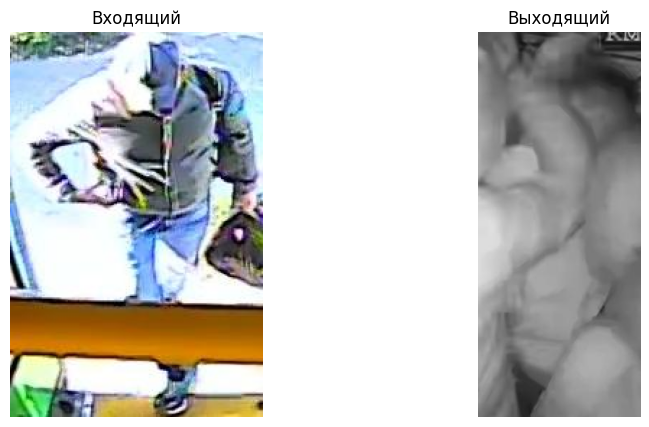

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
# ваше решение
data_files[0]

'/content/bus/Входящий/04359.jpg'

In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 128                           # Ширина изображения
IMG_HEIGHT = 64                           # Высота изображения

In [ ]:
import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (64, 128, 3)
Общий массив данных изображений следующей формы: (9081, 64, 128, 3)
Общий массив меток классов следующей формы: (9081,)


array([[[210, 173, 168],
        [130, 103,  94],
        [ 52,  46,  36],
        ...,
        [124, 189, 211],
        [118, 181, 205],
        [120, 179, 191]],

       [[198, 166, 160],
        [156, 130, 120],
        [ 58,  47,  37],
        ...,
        [ 82, 147, 184],
        [141, 204, 223],
        [ 95, 142, 152]],

       [[191, 164, 158],
        [171, 144, 136],
        [ 66,  49,  40],
        ...,
        [ 63, 129, 177],
        [156, 222, 235],
        [ 46,  91, 103]],

       ...,

       [[245, 253, 255],
        [246, 253, 250],
        [254, 255, 235],
        ...,
        [ 32,  33,  29],
        [107, 112, 108],
        [113, 115, 108]],

       [[247, 251, 249],
        [216, 227, 199],
        [242, 248, 194],
        ...,
        [ 27,  35,  30],
        [ 71,  80,  79],
        [117, 122, 117]],

       [[236, 236, 224],
        [203, 211, 153],
        [247, 252, 128],
        ...,
        [ 32,  40,  35],
        [ 43,  51,  49],
        [111, 116, 111]]], dtype=uint8)
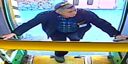

In [ ]:
x_data[0]

In [ ]:
# Нормированние массива изображений
x_data = x_data / 255.

In [ ]:
# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_C (Conv2D)            (None, 64, 128, 256)      7168      
                                                                 
 First_B (BatchNormalizatio  (None, 64, 128, 256)      1024      
 n)                                                              
                                                                 
 Second_C (Conv2D)           (None, 64, 128, 256)      590080    
                                                                 
 Second_M (MaxPooling2D)     (None, 21, 42, 256)       0         
                                                                 
 Third_C (Conv2D)            (None, 21, 42, 256)       590080    
                                                                 
 Third_B (BatchNormalizatio  (None, 21, 42, 256)       1024      
 n)                                                   

In [ ]:
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=35,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/35
291/291 [==============================] - 55s 177ms/step - loss: 0.2631 - accuracy: 0.9188 - val_loss: 0.6090 - val_accuracy: 0.7534
Epoch 2/35
291/291 [==============================] - 48s 166ms/step - loss: 0.1492 - accuracy: 0.9458 - val_loss: 0.7328 - val_accuracy: 0.6175
Epoch 3/35
291/291 [==============================] - 50s 172ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.8914 - val_accuracy: 0.6478
Epoch 4/35
291/291 [==============================] - 48s 165ms/step - loss: 0.0691 - accuracy: 0.9755 - val_loss: 0.2581 - val_accuracy: 0.8982
Epoch 5/35
291/291 [==============================] - 48s 165ms/step - loss: 0.0431 - accuracy: 0.9849 - val_loss: 0.7557 - val_accuracy: 0.7688
Epoch 6/35
291/291 [==============================] - 48s 165ms/step - loss: 0.0302 - accuracy: 0.9895 - val_loss: 0.2898 - val_accuracy: 0.9119
Epoch 7/35
291/291 [==============================] - 50s 171ms/step - loss: 0.0448 - accuracy: 0.9838 - val_loss: 0.1572 - val_ac

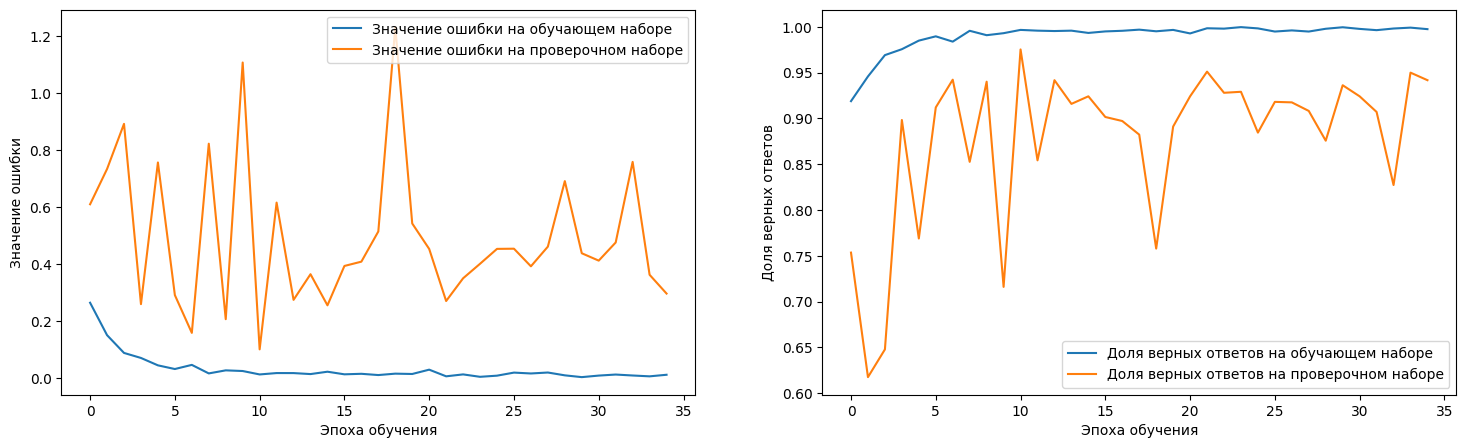

In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

#Вывод
Точность модели на проверочной выборке составила 94%